In [1]:
%%html

<style>    
    @import url("css/custom_styles.css")
</style>

<center>
    <h1>
    Projet
    </h1>
    PlantVillage et Bag Of Visual Words
    <br>
    <br>
    <br>
    <br>
    <b>Frédéric Champagne</b><br>
    <b>Jean-Francois Gagnon</b><br>
    <b>Michèle De la Sablonière</b><br>
    <br>
    420-A52
    <br>
</center>

# Introduction

<font class="answer">
    
Nous avons choisi la base de donnée [Plant Village](https://data.mendeley.com/datasets/tywbtsjrjv/1). Elle se compose de de plus de 60 000 images de feuilles de plante exhibant diverses maladies. Elles sont réparties en 38 differentes classes combiant espèce et maladie. L'objectif de ce projet est donc d'identifier la classe à partir de l'image d'origine. Pour ce faire, nous comptons utiliser la technique "Bag of Visual Words". Elle sera détaillée un peu plus bas dans le rapport.

In [2]:
#
# imports utilitaires
#

%matplotlib inline

import cv2
import random
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd

from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split

#
# imports faisant partie de nos propres modules
# voir l'annexe pour plus de détails
#

import helpers as hlp
import helpers.split as split
import helpers.dataset.PlantVillage as pv
import helpers.features as feat

from helpers.jupyter import display_html

# Prétraitement

<font class="answer">

PlantVillage consiste en un fichier .zip contenant uniquement des images. L'information de classe est encodée dans les chemin des fichiers. Le format est:

<br>
<center>[Espece]__[Maladie]/[image]</center>
    
Nous avons élaborer un processus qui extrait et le normalise cette information. En effet, certains individus ne repectaient pas tout à fait le format attendu. Exemple de traitement:

```python
def _extract_dataframe(config, filename):
    species_disease_pattern = re.compile(config.species_disease_re)
    species_pattern = re.compile(config.species_re)

    labels = filename.split("/")[-2]
    labels_match = species_disease_pattern.match(labels)
    if labels_match is None:
        return None

    plant_species, plant_disease = labels_match.groups()

    # some elements do not respect nomenclature
    # found in litterature: fix it
    species_match = species_pattern.match(plant_species)
    if not species_match is None:
        plant_species = config.label_separator.join(species_match.groups())

    # some elements duplicate plant species within plan disease
    # keep plant species only 1x
    if plant_species in plant_disease:
        label = plant_disease
    else:
        label = config.label_separator.join([plant_species,
                                             plant_disease])
```
    
Nous avons décortiqué la classe en sous composantes pour partager une information concise et uniforme à travers toutes les étapes de notre projet. L'index (voir exploration) nous sert d'identifiant unique. Les colonnes de notre dataframe sont:
* species: Espèce de la plante
* disease: Nom de la maladie
* label: La classe normalisée (combine espèce et maladie)
* image_path: Chemin de l'image correspondante
    
Finalement, toutes les images ont la même dimension. A savoir 256x256.

In [3]:
#
# parametres configurant notre pipeline
#
configs = hlp.get_configs("config_overrides.json")

#
# obtenir le dataset PlantVillage
#
pv_dataset = pv.load(configs.plant_village)
pv_dataframe = pv_dataset.dataframe

display_html(f"<b>Nombre d'individus</b>: {pv_dataframe.shape[0]}")
display(pv_dataframe.head(5))

,species,disease,label,image_path
0,Orange,Haunglongbing_(Citrus_greening),Orange_Haunglongbing_(Citrus_greening),Plant_leave_diseases_dataset_with_augmentation...
1,Tomato,Tomato_mosaic_virus,Tomato_mosaic_virus,Plant_leave_diseases_dataset_with_augmentation...
2,Grape,Esca_(Black_Measles),Grape_Esca_(Black_Measles),Plant_leave_diseases_dataset_with_augmentation...
3,Tomato,Target_Spot,Tomato_Target_Spot,Plant_leave_diseases_dataset_with_augmentation...
4,Orange,Haunglongbing_(Citrus_greening),Orange_Haunglongbing_(Citrus_greening),Plant_leave_diseases_dataset_with_augmentation...


# Exploration

## Question 1 et 2

**Identifier d’abord les classes disponibles dans le dataset que vous avez choisi. Procéder à une exploration du dataset et identifier des valeurs manquantes, inconnues, etc. Procéder au remplacement de ces valeurs s’il y’a lieu.**

<font class="answer">

Nous savons que nous n'avons pas de valeurs manquantes ni inconnues de par notre prétraitement, 

In [7]:
labels = pv_dataframe["label"].unique()
labels.sort()
display_html(f"<b>Modalités des classes</b>: {len(labels)}")
display(list(labels))

['Apple_Black_rot',
 'Apple_Cedar_apple_rust',
 'Apple_healthy',
 'Apple_scab',
 'Blueberry_healthy',
 'Cherry_Powdery_mildew',
 'Cherry_healthy',
 'Corn_Cercospora_leaf_spot Gray_leaf_spot',
 'Corn_Common_rust',
 'Corn_Northern_Leaf_Blight',
 'Corn_healthy',
 'Grape_Black_rot',
 'Grape_Esca_(Black_Measles)',
 'Grape_Leaf_blight_(Isariopsis_Leaf_Spot)',
 'Grape_healthy',
 'Orange_Haunglongbing_(Citrus_greening)',
 'Peach_Bacterial_spot',
 'Peach_healthy',
 'Pepper,_bell_Bacterial_spot',
 'Pepper,_bell_healthy',
 'Potato_Early_blight',
 'Potato_Late_blight',
 'Potato_healthy',
 'Raspberry_healthy',
 'Soybean_healthy',
 'Squash_Powdery_mildew',
 'Strawberry_Leaf_scorch',
 'Strawberry_healthy',
 'Tomato_Bacterial_spot',
 'Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato_Leaf_Mold',
 'Tomato_Septoria_leaf_spot',
 'Tomato_Spider_mites Two-spotted_spider_mite',
 'Tomato_Target_Spot',
 'Tomato_Yellow_Leaf_Curl_Virus',
 'Tomato_healthy',
 'Tomato_mosaic_virus']

In [8]:
species = pv_dataframe["species"].unique()
species.sort()
display_html(f"<b>Modalites des espèces</b>: {species.size}")
display(list(species))

['Apple',
 'Blueberry',
 'Cherry',
 'Corn',
 'Grape',
 'Orange',
 'Peach',
 'Pepper,_bell',
 'Potato',
 'Raspberry',
 'Soybean',
 'Squash',
 'Strawberry',
 'Tomato']

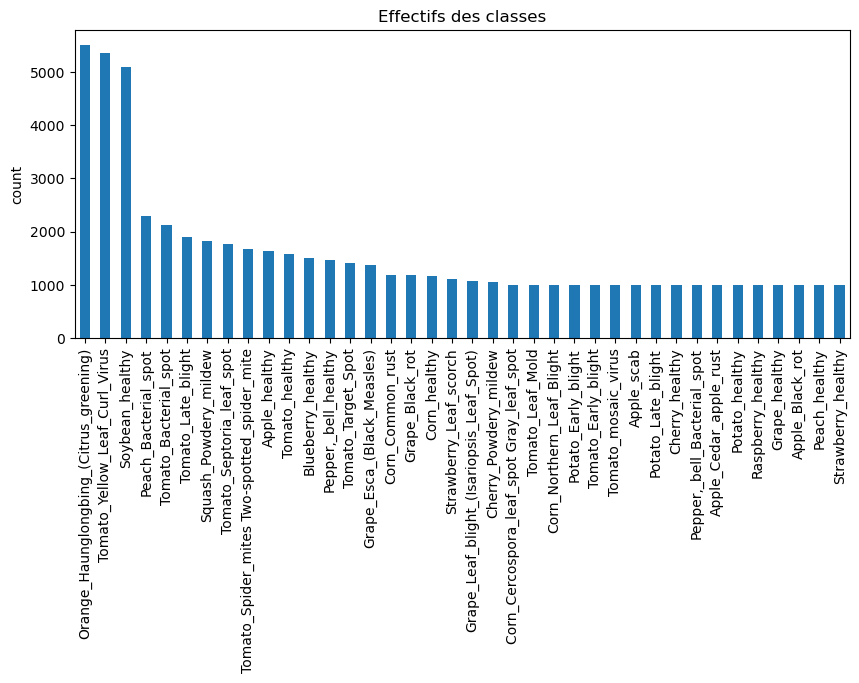

In [9]:
#
# distribution des classes
#
FIGSIZE = (10, 4)

disease_count = pv_dataframe["label"].value_counts()
disease_count.sort_values(inplace=True, ascending=False)

plt.figure(figsize=FIGSIZE)
disease_count.plot.bar(title="Effectifs des classes", ylabel="count")
plt.show()

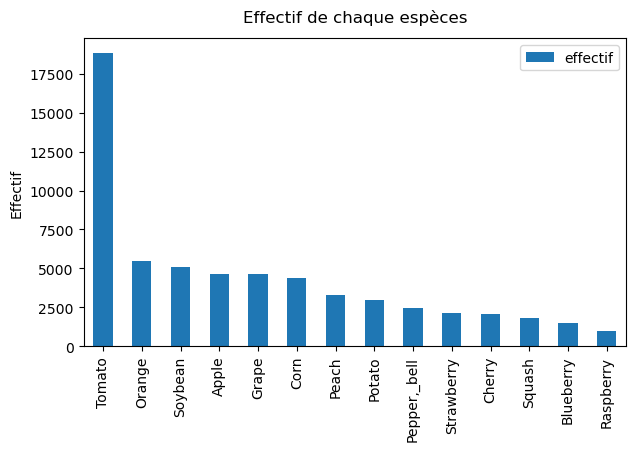

species,Tomato,Orange,Soybean,Apple,Grape,Corn,Peach,Potato,"Pepper,_bell",Strawberry,Cherry,Squash,Blueberry,Raspberry
effectif,18835,5507,5090,4645,4639,4354,3297,3000,2478,2109,2052,1835,1502,1000


In [11]:
#
# relation species/label
#
doi = pv_dataframe[["label", "species"]]

disease_samples_per_species = doi.groupby("species") \
                                 .count() \
                                 .rename(columns={"label": "effectif"})
disease_samples_per_species.sort_values("effectif", inplace=True, ascending=False)

plt.figure(figsize=(7, 4))
disease_samples_per_species.plot.bar(ax=plt.gca(), 
                                     xlabel="", 
                                     ylabel="Effectif")

plt.title("Effectif de chaque espèces", y=1.025)
plt.show()

display( disease_samples_per_species.T )

<font class="answer">
On observe qu'il y a un débalancement dans la répartition des classes et des espèces.

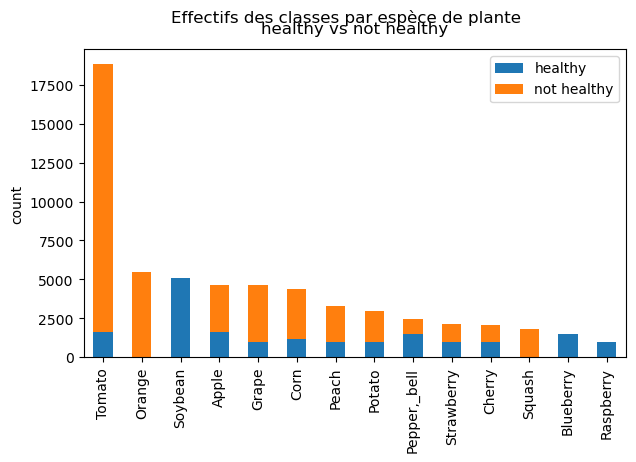

species,Tomato,Orange,Soybean,Apple,Grape,Corn,Peach,Potato,"Pepper,_bell",Strawberry,Cherry,Squash,Blueberry,Raspberry
healthy,1591.0,0.0,5090.0,1645.0,1000.0,1162.0,1000.0,1000.0,1478.0,1000.0,1000.0,0.0,1502.0,1000.0
not healthy,17244.0,5507.0,0.0,3000.0,3639.0,3192.0,2297.0,2000.0,1000.0,1109.0,1052.0,1835.0,0.0,0.0


In [12]:
#
# relation healthy et autres maladies
#
healthy_crit = doi["label"].str.contains("healthy")

healthy = doi[healthy_crit]
healthy = healthy \
            .groupby("species") \
            .count() \
            .rename(columns={"label": "healthy"})

not_healthy = doi[ ~healthy_crit ]
not_healthy = not_healthy \
                .groupby("species") \
                .count() \
                .rename(columns={"label": "not healthy"})

healthy_vs_other_per_species = pd.merge(healthy, 
                                        not_healthy,
                                        how="outer",
                                        on="species")

# pour faciliter la comparison, garder le meme ordre que disease_samples_per_species
healthy_vs_other_per_species = healthy_vs_other_per_species \
                                   .reindex(disease_samples_per_species \
                                   .index.to_list())

fig = plt.figure(figsize=(7, 4))
fig.suptitle("Effectifs des classes par espèce de plante")

healthy_vs_other_per_species.plot.bar(ax=plt.gca(),
                                      stacked=True, 
                                      xlabel="",
                                      ylabel="count")
plt.title("healthy vs not healthy", y=1.025)
plt.show()

display(healthy_vs_other_per_species.replace(np.nan, 0).T)

<font class="answer">

TODO: reformuler par objectif de classifier
    
Nous désirons ignorer les espèces qui ne sont pas représentées dans les deux momdalités (healthy et not healthy). Blueberry, Soybean, Rasberry, Squash et Orange ont donc été écarté.

In [13]:
to_remove = ["Blueberry", "Soybean", "Rasberry", "Squash", "Orange"]
to_remove = pv_dataframe["species"].isin(to_remove)

pv_dataframe_filtered = pv_dataframe[~to_remove]

In [14]:
#Exploration des effectifs de chaque species
def composante(bd, fruit):
    fruit_crit = bd["label"].str.contains(fruit)
    fruit1 = bd[fruit_crit]

    fruit_count = fruit1["label"].value_counts()
    fruit_count.sort_values()

    print("Les composantes de", fruit, "sont")
    display(fruit_count.to_frame())


In [15]:
composante(pv_dataframe_filtered, "Tomato")

Les composantes de Tomato sont


,label
Tomato_Yellow_Leaf_Curl_Virus,5357
Tomato_Bacterial_spot,2127
Tomato_Late_blight,1909
Tomato_Septoria_leaf_spot,1771
Tomato_Spider_mites Two-spotted_spider_mite,1676
Tomato_healthy,1591
Tomato_Target_Spot,1404
Tomato_mosaic_virus,1000
Tomato_Leaf_Mold,1000
Tomato_Early_blight,1000


In [16]:
composante(pv_dataframe_filtered, "Apple")

Les composantes de Apple sont


,label
Apple_healthy,1645
Apple_scab,1000
Apple_Cedar_apple_rust,1000
Apple_Black_rot,1000


In [17]:
composante(pv_dataframe_filtered, "Cherry")

Les composantes de Cherry sont


,label
Cherry_Powdery_mildew,1052
Cherry_healthy,1000


In [18]:
composante(pv_dataframe_filtered, "Corn")

Les composantes de Corn sont


,label
Corn_Common_rust,1192
Corn_healthy,1162
Corn_Northern_Leaf_Blight,1000
Corn_Cercospora_leaf_spot Gray_leaf_spot,1000


In [19]:
composante(pv_dataframe_filtered, "Grape")

Les composantes de Grape sont


,label
Grape_Esca_(Black_Measles),1383
Grape_Black_rot,1180
Grape_Leaf_blight_(Isariopsis_Leaf_Spot),1076
Grape_healthy,1000


In [20]:
composante(pv_dataframe_filtered, "Peach")

Les composantes de Peach sont


,label
Peach_Bacterial_spot,2297
Peach_healthy,1000


In [21]:
composante(pv_dataframe_filtered, "Pepper,_bell")

Les composantes de Pepper,_bell sont


,label
"Pepper,_bell_healthy",1478
"Pepper,_bell_Bacterial_spot",1000


In [22]:
composante(pv_dataframe_filtered, "Potato")

Les composantes de Potato sont


,label
Potato_Early_blight,1000
Potato_Late_blight,1000
Potato_healthy,1000


In [23]:
composante(pv_dataframe_filtered, "Strawberry")

Les composantes de Strawberry sont


,label
Strawberry_Leaf_scorch,1109
Strawberry_healthy,1000


Comme nous avons une grosse base de données nous avons décidé, pour réduire le temps d'exécution et rendre le travail plus facile, de choisir une seule species qui contient plus qu'une maladie et des groupes assez équilibré et des images significatives. Nous allons donc choisir entre Apple, Corn, Grape et Potato. Pour éclairer notre choix nous allons regarder les photos de plus près. 

In [ ]:
def affichage_image(bd, fruit):
    fruit_crit = bd["label"].str.contains(fruit)
    fruit1 = bd[fruit_crit]
    SAMPLES_GRID = (5, 5)

    random.seed(42)
    sample_indices = random.sample(range(fruit1.shape[0]),
                                   SAMPLES_GRID[0] * SAMPLES_GRID[1])
    sample_indices.sort()

    samples = fruit1.iloc[sample_indices]

    FIGSIZE = (10, 10)

    fig = plt.figure(figsize=FIGSIZE)

    for i, (sample_index, sample_data) in enumerate(samples.iterrows()):
        plt.subplot(SAMPLES_GRID[0], SAMPLES_GRID[1], i + 1)
        plt.axis("off")

        species = sample_data['species']
        disease = pv.attribute_prettify(species, sample_data['label'])

        image = pv_dataset.get_image(sample_index)

        plt.title(f"{species}\n{disease}")
        plt.imshow(image)
        plt.gca().title.set_size(10)

    plt.tight_layout()
    fig.subplots_adjust(hspace=0.5, top=0.8)
    plt.show()


In [ ]:
affichage_image(df, "Apple")

In [ ]:
affichage_image(df, "Corn")

In [ ]:
affichage_image(df, "Grape")

In [ ]:
affichage_image(df, "Potato")

En regardant les photos de plus près nous avons constaté que pour les species Apple,Corn et Potato les différences entre les photos des différentes maladies sont moins significatives que pour Grape c'est pourquoi nous avons choisi de garder celle-ci. 

In [ ]:
searchfor = ["Grape"]
group_sel = group_selection(df1, searchfor)


In [ ]:
#Équilibrage des groupes de Grape

x1 = group_sel
y1 = group_sel["label"].values.reshape(-1, 1)


rus = RandomUnderSampler(random_state=42)
x_bal, y_bal = rus.fit_resample(x1, y1)

x = x_bal["label"]

print(x_bal["label"].value_counts())


In [ ]:
# Préparation de deux ensembles train/test pour le reste des étapes
x_train, x_test = train_test_split(
    x,  stratify=x, test_size=0.2, random_state=44)

x_train = x_train.index.to_list()
x_test = x_test.index.to_list()
split.save(configs.split, x_train, x_test)

In [ ]:
%%html

<style>    
    @import url("css/custom_styles.css")
</style>

# Dataset
[Plant Village](https://data.mendeley.com/datasets/tywbtsjrjv/1)

## Description

Dans cette base de données, il y a 39 differentes classes d'image de feuilles. La base de donnée contient 61,486 images.

Les classes sont: 

<br>

<div class="columns_2">
    
1. Apple_scab
2. Apple_black_rot
3. Apple_cedar_apple_rust
4. Apple_healthy
5. Background_without_leaves
6. Blueberry_healthy
7. Cherry_powdery_mildew
8. Cherry_healthy
9. Corn_gray_leaf_spot
10. Corn_common_rust
11. Corn_northern_leaf_blight
12. Corn_healthy
13. Grape_black_rot
14. Grape_black_measles
15. Grape_leaf_blight
16. Grape_healthy
17. Orange_haunglongbing
18. Peach_bacterial_spot
19. Peach_healthy
20. Pepper_bacterial_spot

</div>

<div class="columns_2">
    
21. Pepper_healthy
22. Potato_early_blight
23. Potato_healthy
24. Potato_late_blight
25. Raspberry_healthy
26. Soybean_healthy
27. Squash_powdery_mildew
28. Strawberry_healthy
29. Strawberry_leaf_scorch
30. Tomato_bacterial_spot
31. Tomato_early_blight
32. Tomato_healthy
33. Tomato_late_blight
34. Tomato_leaf_mold
35. Tomato_septoria_leaf_spot
36. Tomato_spider_mites_two-spotted_spider_mite
37. Tomato_target_spot
38. Tomato_mosaic_virus
39. Tomato_yellow_leaf_curl_virus
    
</div>

In [ ]:
%matplotlib inline

#
# import utilitaires
#
import cv2
import random
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd

import helpers as hlp
import helpers.split as split
import helpers.dataset.PlantVillage as pv
import helpers.features as feat

from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from helpers.jupyter import display_html

In [ ]:

# parametres
#
configs = hlp.get_configs("config_overrides.json")

#
# obtenir le dataset PlantVillage
#
with hlp.Profile() as load_profile:
    pv_dataset = pv.load(configs.plant_village)
    pv_dataframe = pv_dataset.dataframe
    
print(f"Loading dataset:", load_profile.round_duration(), "s")

# asdf

# Exploration

In [ ]:
display_html(f"<b>{configs.plant_village.install_path}</b> - data {pv_dataframe.shape}")
display(pv_dataframe.head(5))

In [ ]:
display_html(f"<b>{configs.plant_village.install_path}</b> - info")
pv_dataframe.info()

In [ ]:
species = pv_dataframe["species"].unique()
species.sort()
display_html(f"<b>Modalites de 'species'</b> - count: {species.size}")
display(list(species))

In [ ]:
labels = pv_dataframe["label"].unique()
labels.sort()
display_html(f"<b>Modalites de 'label'</b> - count: {len(labels)}")
display(list(labels))

<font class="answer">

**Notes**
* Background_without_leaves a été intentionellement enlevé
* Les modalités semblent avoir evoluées par rapport à la liste citée ci-haut

In [ ]:
#
# distribution de label
#
FIGSIZE = (10, 4)

disease_count = pv_dataframe["label"].value_counts()
disease_count.sort_values(inplace=True, ascending=False)

plt.figure(figsize=FIGSIZE)
disease_count.plot.bar(title="Effectifs de 'label'",
                       ylabel="count")
plt.show()

In [ ]:
# Verification des valeurs manquantes

display(pv_dataframe[pv_dataframe.isna().any(
    axis=1)].style.highlight_null('green'))


In [ ]:
#
# relation species/label
#
doi = pv_dataframe[["label", "species"]]

disease_samples_per_species = doi.groupby("species").count()
disease_samples_per_species.sort_values("label", inplace=True, ascending=False)

In [ ]:
healthy_crit = doi["label"].str.contains("healthy")

healthy = doi[healthy_crit]
healthy = healthy \
            .groupby("species") \
            .count() \
            .rename(columns={"label": "healthy"})

not_healthy = doi[ ~healthy_crit ]
not_healthy = not_healthy \
                .groupby("species") \
                .count() \
                .rename(columns={"label": "autres"})

healthy_vs_other_per_species = pd.merge(healthy, 
                                        not_healthy,
                                        how="outer",
                                        on="species")

# pour faciliter la comparison, garder le meme ordre que disease_samples_per_species
healthy_vs_other_per_species = healthy_vs_other_per_species \
                                   .reindex(disease_samples_per_species \
                                   .index.to_list())

In [ ]:
fig = plt.figure(figsize=FIGSIZE)
fig.suptitle("Effectifs de 'label' par espece de plante")

plt.subplot(121)
healthy_vs_other_per_species.plot.bar(ax=plt.gca(),
                                      stacked=True, 
                                      xlabel="",
                                      ylabel="count")
plt.title("'healthy' vs autres", y=1.025)

plt.subplot(122)
_, _, pcts = plt.pie(x=disease_samples_per_species.values.flatten(),
                     labels=disease_samples_per_species.index.values,
                     autopct='%.0f%%',
                     radius=1.25,
                     wedgeprops={'linewidth': 1.0, 
                                 'edgecolor': 'white'})
plt.title("Toute maladies confondues", y=1.025)
plt.setp(pcts, color='white')

plt.tight_layout()
plt.show()

In [ ]:
#
# visualiser quelques images
#
SAMPLES_GRID = (2, 7)

# selectionner quelques images aleatoirement (mais pas trop aleatoire)
random.seed(42)
sample_indices = random.sample(range(pv_dataframe.shape[0]), 
                               SAMPLES_GRID[0] * SAMPLES_GRID[1])
sample_indices.sort()

samples = pv_dataframe.iloc[sample_indices]

In [ ]:
# FIGSIZE = (10, 6.5)

fig = plt.figure(figsize=FIGSIZE)

for i, (sample_index, sample_data) in enumerate(samples.iterrows()):
    plt.subplot(SAMPLES_GRID[0], SAMPLES_GRID[1], i + 1)
    plt.axis("off")

    species = sample_data['species']
    disease = pv.attribute_prettify(species, sample_data['disease'])
        
    image = pv_dataset.get_image(sample_index)
    
    plt.title(f"{species}\n{disease}")    
    plt.imshow(image)
    plt.gca().title.set_size(10)

plt.tight_layout()
fig.subplots_adjust(hspace=0.5, top=0.8)
plt.show()

In [ ]:
#Exploration des species
df = pv_dataset.dataframe[["label", "species"]]

nbEspece = df.groupby("species").count()
print("Nombres d'individus dans chaque 'species'",nbEspece)


In [ ]:
healthy_crit = df["label"].str.contains("healthy")
healthy = df[healthy_crit]
healthy = healthy.groupby("species").count()

not_healthy = df[~healthy_crit]
not_healthy = not_healthy.groupby("species").count()
print("Nombre d'individus dans les 'species' Healthy:\n",healthy)
print("Nombre d'individus dans les 'species' qui sont des maladies:\n",not_healthy)

Nous avons effectué une première sélection en enlevant les species qui ne sont pas représenté dans les deux catégories (healthy et not healthy). Blueberry, Soybean, Rasberry, Squash et Orange ont été enlevé.

In [ ]:
def group_selection(df, searchfor):
    crit = '|'.join(searchfor)
    return df[df["label"].str.contains(crit)]


In [ ]:
df1 = pv_dataset.dataframe

searchfor = ["Apple", "Cherry", "Corn", "Grape", "Peach",
             "Pepper,_bell", "Potato", "Strawberry", "Tomato"]
group_sel = group_selection(df1, searchfor)
# in
sel1 = group_sel.groupby("species").count()

print("Species restant dans la première sélection avec leur effectifs\n", sel1)


In [ ]:
#Exploration des effectifs de chaque species
def composante(bd, fruit):
    fruit_crit = bd["label"].str.contains(fruit)
    fruit1 = bd[fruit_crit]

    fruit_count = fruit1["label"].value_counts()
    fruit_count.sort_values

    print("Les composantes de", fruit, "sont :\n", fruit_count)


In [ ]:
composante(df, "Tomato")

In [ ]:
composante(df, "Apple")


In [ ]:
composante(df, "Cherry")


In [ ]:
composante(df, "Corn")

In [ ]:
composante(df, "Grape")

In [ ]:
composante(df, "Peach")

In [ ]:
composante(df, "Pepper,_bell")

In [ ]:
composante(df, "Potato")

In [ ]:
composante(df, "Strawberry")

Comme nous avons une grosse base de données nous avons décidé, pour réduire le temps d'exécution et rendre le travail plus facile, de choisir une seule species qui contient plus qu'une maladie et des groupes assez équilibré et des images significatives. Nous allons donc choisir entre Apple, Corn, Grape et Potato. Pour éclairer notre choix nous allons regarder les photos de plus près. 

In [ ]:
def affichage_image(bd, fruit):
    fruit_crit = bd["label"].str.contains(fruit)
    fruit1 = bd[fruit_crit]
    SAMPLES_GRID = (5, 5)

    random.seed(42)
    sample_indices = random.sample(range(fruit1.shape[0]),
                                   SAMPLES_GRID[0] * SAMPLES_GRID[1])
    sample_indices.sort()

    samples = fruit1.iloc[sample_indices]

    FIGSIZE = (10, 10)

    fig = plt.figure(figsize=FIGSIZE)

    for i, (sample_index, sample_data) in enumerate(samples.iterrows()):
        plt.subplot(SAMPLES_GRID[0], SAMPLES_GRID[1], i + 1)
        plt.axis("off")

        species = sample_data['species']
        disease = pv.attribute_prettify(species, sample_data['label'])

        image = pv_dataset.get_image(sample_index)

        plt.title(f"{species}\n{disease}")
        plt.imshow(image)
        plt.gca().title.set_size(10)

    plt.tight_layout()
    fig.subplots_adjust(hspace=0.5, top=0.8)
    plt.show()


In [ ]:
affichage_image(df, "Apple")

In [ ]:
affichage_image(df, "Corn")

In [ ]:
affichage_image(df, "Grape")

In [ ]:
affichage_image(df, "Potato")

En regardant les photos de plus près nous avons constaté que pour les species Apple,Corn et Potato les différences entre les photos des différentes maladies sont moins significatives que pour Grape c'est pourquoi nous avons choisi de garder celle-ci. 

In [ ]:
searchfor = ["Grape"]
group_sel = group_selection(df1, searchfor)


In [ ]:
#Équilibrage des groupes de Grape

x1 = group_sel
y1 = group_sel["label"].values.reshape(-1, 1)


rus = RandomUnderSampler(random_state=42)
x_bal, y_bal = rus.fit_resample(x1, y1)

x = x_bal["label"]

print(x_bal["label"].value_counts())


In [ ]:
# Préparation de deux ensembles train/test pour le reste des étapes
x_train, x_test = train_test_split(
    x,  stratify=x, test_size=0.2, random_state=44)

x_train = x_train.index.to_list()
x_test = x_test.index.to_list()
split.save(configs.split, x_train, x_test)

In [ ]:
%matplotlib inline

#
# import utilitaires
#
import matplotlib.pyplot as plt
import random

import helpers as hlp
import helpers.dataset.PlantVillage as pv
import helpers.features as feat

from pathlib import Path
from rembg import remove, new_session
import zipfile
import os
import time

In [ ]:
#
# parametres
#
configs = hlp.get_configs("config_overrides.json")

#
# obtenir le dataset PlantVillage
#
pv_dataset = pv.load(configs.plant_village)

if pv_dataset is None:
    print("Invalid dataset")
else:
    pv_dataframe = pv_dataset.dataframe

print("PlantVillage", pv_dataframe.shape)
display( pv_dataframe.head() )

Etant donne que les features vont être utilisées tout au long de notre pipeline, nous processons tous le dataset une seul fois et mettons en cache les résultats. 

In [ ]:
# if not os.path.exists("dataset/Plant_leaf_diseases_dataset_with_augmentation"):
#     with zipfile.ZipFile("dataset/Plant_leaf_diseases_dataset_with_augmentation.zip", 'r') as zip_ref:
#         zip_ref.extractall("dataset/Plant_leaf_diseases_dataset_with_augmentation")
# '''
# session = new_session()

# for root, dirs, files in os.walk('dataset/Plant_leaf_diseases_dataset_with_augmentation'):

#     for file in Path(root).glob('*.JPG'):
#         input_path = str(file)
#         output_path = str(file.parent / (file.stem + ".out.png"))

#         with open(input_path, 'rb') as i:
#             with open(output_path, 'wb') as o:
#                 input = i.read()
#                 output = remove(input, session=session)
#                 o.write(output)
#                 time.sleep(0.2)
# '''                
# print(pv_dataset.get_image(60342))


In [ ]:
#
# features orb
#

# pour debugger, s'assurer que le fichier de features 
# est detruit a chaque execution de la cellule
if "orb_features" in locals():
    del orb_features

with hlp.Profile() as orb_loading:
    #
    # obtenir les orb features pour chaque image du dataset
    #
    orb_iter = feat.DatasetIter(pv_dataset, 
                                pv_dataframe["image_path"].items(),
                                pv_dataframe.shape[0])

    # la premiere execution va mettre en cache les resultats
    orb_features = feat.load(configs.orb, orb_iter)

print(f"ORB loading:", orb_loading.round_duration(), "s")
print("ORB features", orb_features.features.shape)
print("ORB keypoints", orb_features.key_points.shape)

In [ ]:
#
# features sift
#

# pour debugger, s'assurer que le fichier de features 
# est detruit a chaque execution de la cellule
if "sift_features" in locals():
    del sift_features

with hlp.Profile() as sift_loading:
    #
    # obtenir les sift features pour chaque image du dataset
    #
    sift_iter = feat.DatasetIter(pv_dataset, 
                                 pv_dataframe["image_path"].items(),
                                 pv_dataframe.shape[0])

    # la premiere execution va mettre en cache les resultats
    sift_features = feat.load(configs.sift, sift_iter)

print(f"SIFT loading:", sift_loading.round_duration(), "s")
print("SIFT features", sift_features.features.shape)
print("SIFT keypoints", sift_features.key_points.shape)

In [ ]:
SAMPLES_GRID = (2, 4)
FIGSIZE = (10, SAMPLES_GRID[0] * 3.5)

def affiche_image(features, indices):
    dataset_iter = feat.DatasetIter(pv_dataset, 
                                    pv_dataframe.loc[indices, "image_path"].items())

    _, axes = plt.subplots(SAMPLES_GRID[0], SAMPLES_GRID[1], figsize=FIGSIZE)
    for ax, \
       (image_index, \
        _, \
        key_points_count, \
        key_points_image) in zip(axes.flatten(), feat.key_points_iter(features, dataset_iter)):    
        if key_points_image is None:
            continue
        plt.sca(ax)

        species, disease = pv_dataframe.loc[image_index, ["species", "disease"]]
        disease = pv.attribute_prettify(species, disease)
        title = "\n".join([species, disease, str(key_points_count)])

        plt.title(title)
        plt.axis("off")
        plt.imshow(key_points_image)

In [ ]:
# selectionner quelques images aleatoirement
random.seed(55)
indices = random.sample(range(pv_dataframe.shape[0]), SAMPLES_GRID[0] * SAMPLES_GRID[1])
indices.sort()


#
# visualiser quelques orb keypoints
#
affiche_image(orb_features, indices)

plt.suptitle("ORB keypoints")
plt.tight_layout()
plt.show()


#
# visualiser quelques sift keypoints (les memes que orb)
#
affiche_image(sift_features, indices)

plt.suptitle("SIFT keypoints")
plt.tight_layout()
plt.show()

In [ ]:
%matplotlib inline

#
# import utilitaires
#
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle

import helpers as hlp
import helpers.split as split
import helpers.visual_words as vw
import helpers.features as feat

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [ ]:
#
# parametres
#
configs = hlp.get_configs("config_overrides.json")

#
# train/test sets
# 
train, test = split.load(configs.split)
print("Train size", len(train))
print("Test size", len(test))
print()

#
# features orb
#
# mettre a jour train/test set features
configs.orb.read_only = False
orb_features = feat.load(configs.orb, None)
if configs.orb.force_generate or orb_features.train_features is None:
    feat.update_train_test(orb_features, train, test)

print("ORB features", orb_features.features.shape)
print("ORB train features", orb_features.train_features.shape)
print("ORB test features", orb_features.test_features.shape)
print()

#
# features sift
#
configs.sift.read_only = False
sift_features = feat.load(configs.sift, None)
if configs.sift.force_generate or sift_features.train_features is None:
    feat.update_train_test(sift_features, train, test)

print("SIFT features", sift_features.features.shape)
print("SIFT train features", sift_features.train_features.shape)
print("SIFT test features", sift_features.test_features.shape)

Etant donnée que les descripteurs des images représentent un apport important à la quantité de données à traiter (14 382 049 de descripteurs pour 3 711 images, plus de 3 ordres de grandeurs en quantité), nous voulons optimiser cet impact. Une analyse PCA nous permettra de les transformer pour éventuellment réduire leurs dimensions. 

In [ ]:
def features_pca(x):
    pca_pipeline = Pipeline([("scaler", StandardScaler()),
                             ("pca", PCA(svd_solver="full"))])
    pca_pipeline.fit(x)
    return pca_pipeline

def features_pca_analysis(pca_model, title_prefix, threshold=None, figsize=(5, 3)):
    var_ratio = pca_model.explained_variance_ratio_
    inertia = np.cumsum(var_ratio)

    plt.figure(figsize=figsize)
    plt.plot(range(inertia.shape[0]), inertia, marker=".")
    if not threshold is None:
        plt.axhline(y=threshold, color="red", linestyle="-")
    plt.grid()
    plt.title(f"{title_prefix}\n% variance expliquée vs # composantes")
    plt.show()

In [ ]:
with hlp.Profile() as orb_features_pca_profile:
    orb_features_pca = features_pca(orb_features.train_features)

print("ORB Features PCA:", orb_features_pca_profile.round_duration(), "s")
print("ORB Features PCA valeurs propres:")
print(orb_features_pca["pca"].explained_variance_)

features_pca_analysis(orb_features_pca["pca"], "ORB", 0.95)

Le graphique précédant n'exhibe pas de "coude franc". Nous établisons donc un seuil à 95% ce qui permet de garder 26 composantes sur les 32 d'origine. Ce paramètre est intégré dans notre pipeline dans l'étape suivante via les fichiers de configuration.  

In [ ]:
# ATTENTION: cette etape peut etre longue a la 1e execution
#            elle est sans feedback visuel, soyez patient
with hlp.Profile() as orb_bovw_profile:
    orb_bovw = vw.load_bovw(configs.orb_bovw, orb_features.train_features)

print("ORB BoVW loading:", orb_bovw_profile.round_duration(), "s")
print("ORB BoVW clusters:", orb_bovw.cluster_centers.shape)

In [ ]:
with hlp.Profile() as sift_features_pca_profile:
    sift_features_pca = features_pca(sift_features.train_features)

In [ ]:
print("ORB Features PCA:", sift_features_pca_profile.round_duration(), "s")
print("ORB Features PCA valeurs propres:")
print(sift_features_pca["pca"].explained_variance_)

features_pca_analysis(sift_features_pca["pca"], "SIFT", 0.95, (8, 4))

De la même manière que précédement, nous établisons donc un seuil à 95% ce qui permet de garder 80 composantes sur les 128 d'origine. Ce paramètre est intégré dans notre pipeline dans l'étape suivante via les fichiers de configuration.

In [ ]:
# ATTENTION: cette etape peut etre longue a la 1e execution
#            elle est sans feedback visuel, soyez patient
with hlp.Profile() as sift_bovw_profile:
    sift_bovw = vw.load_bovw(configs.sift_bovw, sift_features.train_features)

print("SIFT BoVW loading:", sift_bovw_profile.round_duration(), "s")
print("SIFT BoVW clusters:", sift_bovw.cluster_centers.shape)

In [ ]:
#
# import utilitaires
#
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random

import helpers as hlp
import helpers.split as split
import helpers.dataset.PlantVillage as pv
import helpers.features as feat
import helpers.visual_words as vw

In [ ]:
#
# parametres
#
configs = hlp.get_configs("config_overrides.json")

# pour update tf-idf
configs.orb_bovw.read_only = False
configs.sift_bovw.read_only = False


#
# dataset PlantVillage
#
pv_dataset = pv.load(configs.plant_village)
pv_dataframe = pv_dataset.dataframe

print("Dataset", pv_dataframe.shape)
print()


#
# train/test
#
train, test = split.load(configs.split)

print("Train size:", len(train))
print("Test size:", len(test))
print()

#
# orb
#
orb_features = feat.load(configs.orb, None)
orb_bovw = vw.load_bovw(configs.orb_bovw, None)

print("ORB features:", orb_features.features.shape)
print("ORB BoVW clusters:", orb_bovw.cluster_centers.shape)
print()


#
# sift
#
sift_features = feat.load(configs.sift, None)
sift_bovw = vw.load_bovw(configs.sift_bovw, None)

print("Sift features:", sift_features.features.shape)
print("Sift BoVW clusters:", sift_bovw.cluster_centers.shape)

In [ ]:
#
# export en batch des visual words orb
#

# pour debugger, s'assurer que le fichier de visual words 
# est detruit a chaque execution de la cellule
if "orb_pv_vw" in locals():
    del orb_pv_vw

with hlp.Profile() as orb_pv_vw_loading:
    orb_pv_vw = vw.load_dataset_vw(configs.orb_dataset_vw,
                                   orb_features,
                                   configs.orb_bovw,
                                   orb_bovw,
                                   train,
                                   test)
    
print(f"ORB PlantVillage Visual Word loading:", orb_pv_vw_loading.round_duration(), "s")
print("ORB PlantVillage Visual Words", orb_pv_vw.vw_freqs.shape)

In [ ]:
# a = np.ravel( orb_bovw.idf )
# b = np.ravel( orb_pv_vw.index_to_vw_freqs["46984"] )
# c = np.multiply(a, b)

# plt.figure( figsize=(10, 6) )

# plt.subplot(311)
# plt.title("idf")
# plt.bar(range(500), a)

# plt.subplot(312)
# plt.title("tf")
# plt.bar(range(500), b)

# plt.subplot(313)
# plt.title("tf-idf")
# plt.bar(range(500), c)

# plt.tight_layout()
# plt.show()

In [ ]:
#
# export en batch des visual words sift
#

# pour debugger, s'assurer que le fichier de visual words 
# est detruit a chaque execution de la cellule
if "sift_pv_vw" in locals():
    del sift_pv_vw

with hlp.Profile() as sift_pv_vw_loading:
    sift_pv_vw = vw.load_dataset_vw(configs.sift_dataset_vw, 
                                    sift_features,
                                    configs.sift_bovw,
                                    sift_bovw,
                                    train,
                                    test)

print(f"sift PlantVillage Visual Word loading:", sift_pv_vw_loading.round_duration(), "s")
print("sift PlantVillage Visual Words", sift_pv_vw.vw_freqs.shape)

In [ ]:
SAMPLES_GRID = (4, 2)
SAMPLES_COUNT = SAMPLES_GRID[0]
FIGSIZE = (10, SAMPLES_GRID[0] * 2.5)

def affiche_image(image_indices, bovw, features, pv_vw):
    x_range = range(bovw.cluster_centers.shape[0])
    idf = np.ravel(bovw.idf)
    
    figure, axes = plt.subplots(SAMPLES_GRID[0],
                                SAMPLES_GRID[1],
                                figsize=FIGSIZE,
                                width_ratios=[1, 3])

    for i, image_index in enumerate(image_indices):
        key_points = features.index_to_key_points[str(image_index)][...]
        visual_words_freq = pv_vw.index_to_vw_freqs[str(image_index)][...].flatten()
        tf_idf = np.multiply(idf, visual_words_freq)

        image = pv_dataset.get_image(image_index)
        image_key_points = feat.draw_key_points(image, key_points)

        species, disease = pv_dataframe.loc[image_index, ["species", "disease"]]
        disease = pv.attribute_prettify(species, disease)
        title = "\n".join([species, disease])

        plt.sca(axes[i, 0])
        plt.gca().set_ylabel(title)
        plt.gca().set_xticks([])
        plt.gca().set_yticks([])
        plt.imshow(image_key_points)

        plt.sca(axes[i, 1])
        plt.bar(x_range, tf_idf)

    axes[0, 0].set_title("Key Points")
    axes[0, 1].set_title("tf-idf Visual Words")

In [ ]:
# selectionner quelques images aleatoirement
random.seed(33)
image_indices = random.choices(train, k=SAMPLES_COUNT)
image_indices.sort()

#
# visualiser quelques visual words orb
#
affiche_image(image_indices,
              orb_bovw,
              orb_features, 
              orb_pv_vw)

plt.suptitle("ORB")
plt.tight_layout()
plt.show() 

In [ ]:
#
# visualiser quelques visual words sift (memes que orb)
#
affiche_image(image_indices,
              sift_bovw,
              sift_features, 
              sift_pv_vw)

plt.suptitle("SIFT")
plt.tight_layout()
plt.show() 
    
# figure.savefig(f"{vw_title}_visual_words.png")

In [ ]:
%matplotlib inline

#
# import utilitaires
#
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle
import random
import seaborn as sns
import warnings

import helpers as hlp
import helpers.features as feat
import helpers.dataset.PlantVillage as pv
import helpers.split as split
import helpers.visual_words as vw

from sklearn.cluster import MiniBatchKMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score, \
    f1_score, \
    confusion_matrix, \
    ConfusionMatrixDisplay, \
    calinski_harabasz_score, \
    davies_bouldin_score

from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from tqdm.notebook import tqdm

# enlever FutureWarning de sklearn 
warnings.simplefilter(action='ignore', category=FutureWarning)

In [ ]:
#
# parametres
#
configs = hlp.get_configs("config_overrides.json")


#
# train/test sets
# 
train, test = split.load(configs.split)
print("Train size", len(train))
print("Test size", len(test))


#
# dataset PlantVillage
#
pv_dataset = pv.load(configs.plant_village)
pv_dataframe = pv_dataset.dataframe

print("Dataset", pv_dataframe.shape)

In [ ]:
#
# features sift
#

configs.sift.force_generate = True
configs.sift.read_only = False

if "sift_features" in locals():
    del sift_features

with hlp.Profile() as sift_loading:
    #
    # obtenir les sift features pour chaque image du dataset
    #
    sift_iter = feat.DatasetIter(pv_dataset, 
                                 pv_dataframe.loc[train + test, "image_path"].items(),
                                 len(train + test))
    sift_features = feat.load(configs.sift, sift_iter)

print(f"SIFT loading:", sift_loading.round_duration(), "s")
print("SIFT keypoints", sift_features.key_points.shape)
print("SIFT features", sift_features.features.shape)

if configs.sift.force_generate or sift_features.train_features is None:
    feat.update_train_test(sift_features, train, test)

print("SIFT train features", sift_features.train_features.shape)
print("SIFT test features", sift_features.test_features.shape)

In [ ]:
#
# reduction des features (voir notebook precedant pour savoir combien de component on garde sur SIFT)
#

pca_pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("pca", PCA(n_components=configs.sift_bovw.pca_n_components, svd_solver="full", random_state=42))
     ])
sift_train_features_pca = pca_pipe.fit_transform(sift_features.train_features);

La litérature est relativement large sur le sujet des clusters. En effet, les techniques de regorupement par densité, par hiéarchie et distance sont toutes explorées. Cependant, nos expérimentations nous ont montrées que seul **MiniBatchKMeans** converge. En effet DBSCAN, SpectralClustering et autres ne terminent pas dans un temps raisonable ou crash tout simplement.

Il est difficile d'évaluer visuellement la qualité de notre clustering etant donné la dimentionalité de nos données. PCA et TSNE ne nous montrent pas un regroupement clair. Nous avons donc opté pour une approche plus simple. A savoir des clusters compactes quitte à avoir beaucoup de chevauchement. Nos métriques sont donc l'inertie (graphe en coude) et **skelarn.metrics.davies_bouldin_score** (recherche valeur minimale). 

* Mettre note pour epliquer **davies_bouldin_score**.
* https://scikit-learn.org/stable/modules/clustering.html#clustering-evaluation
* https://towardsdatascience.com/cheat-sheet-to-implementing-7-methods-for-selecting-optimal-number-of-clusters-in-python-898241e1d6ad
* Est-ce que resampler les features auraient du etre fait? Voir graphes et notes dans [06 - Training - Analyse et recommendations](<06 - Training - Analyse et recommendations.ipynb>)

In [ ]:
cluster_range = range(55, 501, 10)
cluster_scores = [[],[]]
for n_clusters in tqdm(cluster_range):
    cluster_model = MiniBatchKMeans(n_clusters=n_clusters,
                                    batch_size=256 * 12,
                                    random_state=42,
                                    n_init="auto")
    cluster_labels = cluster_model.fit_predict(sift_train_features_pca)

    # mesure la similarite entre les clusters; lower is better
    david_boutin = davies_bouldin_score(sift_train_features_pca, cluster_labels)

    # pour trouver un coude
    inertia = cluster_model.inertia_

    # prendre en note les mesures
    cluster_scores[0].append(david_boutin)
    cluster_scores[1].append(inertia)

    

    
# afficher les mesures
plt.figure(figsize=(12, 4))

plt.subplot(121)
plt.title("davies_bouldin_score")
plt.plot(cluster_range, cluster_scores[0], marker=".")

plt.subplot(122)
plt.title("Model inertia")
plt.plot(cluster_range, cluster_scores[1], marker=".")

plt.tight_layout()
plt.show()

D'après le graphe ci-haut, un bon nombre de clusters serait dans l'interval 100 à 200: minimum marqué par davies_bouldin_score et l'inflexion dans le diagrame de l'inertie semble devenir plutôt linéaire. Notre choix s'arrête donc sur 175. Cette information sera intégrée via nos fichiers de configuration.

In [ ]:
#
# bovw sift
#

configs.sift_bovw.force_generate = True

if "sift_bovw" in locals():
    del sift_bovw

# soyez patient, ce n'est pas interactif
with hlp.Profile() as sift_bovw_profile:
    sift_bovw = vw.load_bovw(configs.sift_bovw, sift_features.train_features)

print("SIFT BoVW loading:", sift_bovw_profile.round_duration(), "s")
print("SIFT BoVW clusters:", sift_bovw.cluster_centers.shape)

In [ ]:
#
# dataset vw sift
#

configs.sift_dataset_vw.force_generate = True

if "sift_pv_vw" in locals():
    del sift_pv_vw

with hlp.Profile() as sift_pv_vw_loading:
    sift_pv_vw = vw.load_dataset_vw(configs.sift_dataset_vw,
                                   sift_features,
                                   configs.sift_bovw,
                                   sift_bovw,
                                   train,
                                   test)
    
print(f"SIFT PlantVillage Visual Word loading:", sift_pv_vw_loading.round_duration(), "s")
print("SIFT PlantVillage Visual Words", sift_pv_vw.vw_freqs.shape)

In [ ]:
#
# visualiser quelques visual words sift
#

SAMPLES_GRID = (4, 2)
SAMPLES_COUNT = SAMPLES_GRID[0]
FIGSIZE = (10, SAMPLES_GRID[0] * 2.5)

def affiche_vw(image_indices, bovw, features, pv_vw):
    x_range = range(bovw.cluster_centers.shape[0])
    idf = np.ravel(bovw.idf)
    
    figure, axes = plt.subplots(SAMPLES_GRID[0],
                                SAMPLES_GRID[1],
                                figsize=FIGSIZE,
                                width_ratios=[1, 3])

    for i, image_index in enumerate(image_indices):
        key_points = features.index_to_key_points[str(image_index)][...]
        visual_words_freq = pv_vw.index_to_vw_freqs[str(image_index)][...].flatten()
        tf_idf = np.multiply(idf, visual_words_freq)

        image = pv_dataset.get_image(image_index)
        image_key_points = feat.draw_key_points(image, key_points)

        species, disease = pv_dataframe.loc[image_index, ["species", "disease"]]
        disease = pv.attribute_prettify(species, disease)
        title = "\n".join([species, disease])

        plt.sca(axes[i, 0])
        plt.gca().set_ylabel(title)
        plt.gca().set_xticks([])
        plt.gca().set_yticks([])
        plt.imshow(image_key_points)

        plt.sca(axes[i, 1])
        plt.bar(x_range, tf_idf)

    axes[0, 0].set_title("Key Points")
    axes[0, 1].set_title("tf-idf Visual Words")
    

# selectionner quelques images aleatoirement
random.seed(55)
image_indices = random.choices(train, k=SAMPLES_COUNT)
image_indices.sort()

affiche_vw(image_indices,
           sift_bovw,
           sift_features, 
           sift_pv_vw)

plt.suptitle("SIFT")
plt.tight_layout()
plt.show() 

In [ ]:
#
# mettre le data dans une forme acceptable pour sklearn
#
train_y = pv_dataframe.loc[train, "label"]
test_y = pv_dataframe.loc[test, "label"]

# sift_pv_vw* garantissent l'ordre donne par train/test lors de l'etape precedante 
# alors faire gaffe a ne pas le changer
sift_train_x = np.multiply(sift_pv_vw.train_vw_freqs[...], sift_bovw.idf)
sift_test_x = np.multiply(sift_pv_vw.test_vw_freqs[...], sift_bovw.idf)

assert sift_train_x.shape[0] == train_y.shape[0]
assert sift_test_x.shape[0] == test_y.shape[0]

print("SIFT PlantVillage train Visual Words", sift_train_x.shape)
print("SIFT PlantVillage test Visual Words", sift_test_x.shape)

Validation de **sift_train_x** juste avant la classification. On veut s'assurer qu'il y ait très peu de corrélation entre les featues.

In [ ]:
# transpose parce que numpy veux les variables dans les rangees
corr = np.corrcoef( sift_train_x.T )

# enlever 1 et -1
corr_no_one = np.where(np.isclose(corr, 1), 0, corr)
corr_max = np.max(corr_no_one)
corr_min = np.min(corr_no_one)

CORR_THRESHOLD = 0.6
corr_thresholded = np.where(abs(corr) > CORR_THRESHOLD, corr, 0)


plt.figure(figsize=(10, 5))

plt.subplot(121)
sns.heatmap(corr, cbar=False)
plt.xticks([])
plt.yticks([])

plt.subplot(122)
plt.title(f"corrélation > abs({CORR_THRESHOLD})")
sns.heatmap(corr_thresholded, cbar=False)
plt.xticks([])
plt.yticks([])

plt.suptitle(f"Corrélation heatmap {corr.shape}\nmin: {round(corr_min, 3)}, max: {round(corr_max, 3)}")
plt.tight_layout()
plt.show()

In [ ]:
def load_knn(model_filename, train_x, train_y):
    """
    Utilitaire pour entrainer un model et le serialiser
    """
    if False and os.path.exists(model_filename):
        # charger le modele pre-entrainer
        with open(model_filename, "rb") as file:
            pipe = pickle.load(file)
    else:
        # trouver meilleurs parametres pour n_neighbors
        CROSS_VALIDATION_FOLDS = 5
        
        pipe = Pipeline([("scaler", StandardScaler()),
                         ("knn", KNeighborsClassifier(n_jobs=-1))])

        pipe_parameters = {"knn__n_neighbors": range(1, 5),
                           "knn__weights": ["uniform", "distance"]}

        grid_search = GridSearchCV(pipe, 
                                  pipe_parameters, 
                                  scoring="accuracy",
                                  refit=True,
                                  cv=CROSS_VALIDATION_FOLDS)

        with hlp.Profile() as grid_search_time:
            grid_search.fit(train_x, train_y)

        # sauvegarde du meilleur modele knn
        pipe = grid_search.best_estimator_
        head, _ = os.path.split(model_filename)
        os.makedirs(head, exist_ok=True)
        with open(model_filename, "wb") as file:
            pickle.dump(pipe, file)

        # afficher quelques stats
        print("Search time:", grid_search_time.round_duration(), "s")
        print("Best params", grid_search.best_params_)
        print("Train score:", grid_search.best_score_.round(4))
        print()
            
    return pipe

def analysis_knn(method_name, pipe, test_x, test_y):
    test_y_hat = pipe.predict(test_x)

    print(method_name, "KNN n_neighbors:", pipe.named_steps["knn"].n_neighbors)
    print(method_name, "KNN test score:", accuracy_score(test_y, test_y_hat).round(4))
    print(method_name, "KNN f1 score:", f1_score(test_y, test_y_hat, average="micro").round(4))
    print()
    print("Effectifs test set:")
    print( test_y.value_counts() )

    # confusion matrix
    plt.figure(figsize=(5, 4))

    cm = confusion_matrix(test_y, test_y_hat)
    cmd = ConfusionMatrixDisplay(cm, display_labels=pipe.classes_)
    cmd.plot(ax=plt.gca())
    cmd.im_.colorbar.remove()

    plt.title(f"{method_name} - KNN - Confusion matrix")
    plt.xticks(rotation=90)
    plt.show()

#
# SIFT KNN
#
sift_knn_pipe = load_knn("models/sift_knn.pkl", sift_train_x, train_y)
analysis_knn("SIFT", sift_knn_pipe, sift_test_x, test_y)

In [ ]:
def load_rf(model_filename, train_x, train_y):
    """
    Utilitaire pour entrainer un model et le serialiser
    """
    if False and os.path.exists(model_filename):
        # charger le modele pre-entrainer
        with open(model_filename, "rb") as file:
            pipe = pickle.load(file)
    else:
        # trouver meilleurs parametres pour n_neighbors
        CROSS_VALIDATION_FOLDS = 5

        pipe = Pipeline([("scaler", StandardScaler()),
                         ("forest_gump", RandomForestClassifier(random_state=42, n_jobs=-1))])

        pipe_parameters = {"forest_gump__n_estimators": range(50, 200)}

        grid_search = GridSearchCV(pipe, 
                                  pipe_parameters, 
                                  scoring="accuracy",
                                  refit=True,
                                  cv=CROSS_VALIDATION_FOLDS,
                                  n_jobs=-1)

        with hlp.Profile() as grid_search_time:
            grid_search.fit(train_x, train_y)

        # sauvegarde du meilleur modele knn
        pipe = grid_search.best_estimator_
        head, _ = os.path.split(model_filename)
        os.makedirs(head, exist_ok=True)
        with open(model_filename, "wb") as file:
            pickle.dump(pipe, file)

        # afficher quelques stats
        print("Search time:", grid_search_time.round_duration(), "s")
        print("Best params", grid_search.best_params_)
        print("Train score:", grid_search.best_score_.round(4))
        print()
            
    return pipe

def analysis_rf(method_name, pipe, test_x, test_y):
    test_y_hat = pipe.predict(test_x)

    print(method_name, "Random Forest n_estimators:", pipe.named_steps["forest_gump"].n_estimators)
    print(method_name, "Random Forest test score:", accuracy_score(test_y, test_y_hat).round(4))
    print(method_name, "Random f1 score:", f1_score(test_y, test_y_hat, average="micro").round(4))
    print()
    print("Effectifs test set:")
    print( test_y.value_counts() )

    # confusion matrix
    plt.figure(figsize=(5, 4))

    cm = confusion_matrix(test_y, test_y_hat)
    cmd = ConfusionMatrixDisplay(cm, display_labels=pipe.classes_)
    cmd.plot(ax=plt.gca())
    cmd.im_.colorbar.remove()

    plt.title(f"{method_name} - Random Forest - Confusion matrix")
    plt.xticks(rotation=90)
    plt.show()
    

#
# SIFT Random Forest
#
sift_rf_pipe = load_rf("models/sift_random_forest.pkl", sift_train_x, train_y)
analysis_rf("SIFT", sift_rf_pipe, sift_test_x, test_y)

# Annexe

<font class="answer">
    
Les objectifs secondaires de ce projet étaient d'abord se familiariser avec des données un peu plus complexes par leur volumes et par leur nature puis d'adresser le travail collaboratif. En effet, en milieu de travail ou non, le partage de résultats et le temps d'itération sont des facteurs déterminant pour le succès. Cette section détaillera les solutions que nous proposons.

## Organisation du travail

<font class="answer">

Notre méthode à haut niveau est une approche en "pipeline": chaque coéquipier se concentre sur une étape et produit un fichier qui pourra être consommer par l'étape suivante. Ceci permet de decoupler les tâches et le travail en parralèle.

Des modules python permettent de définir les interface de chacune des étapes (et d'éviter la duplication d'information). Un effet secondaire bénifique de cette approche est la configurabilité. A haut niveau, aucun code n'a besoin d'être modifié pour expérimenté. Seulement le fichier de configuration. Finalement git est utilisé pour communiqué tout changement à toute l'équipe.

<br>

<div class="columns_2">
Structure fichiers
<img src="images/structure_fichiers.png" width="50%">
</div>


<div class="columns_2">
Structure modules python
<img src="images/modules_python.png" width="35%">
</div>

## Reproductibilité

<font class="answer">
Parler des .yaml et pip config

## Automatisation

<font class="answer">
Parler de

## Temps itération

<font class="answer">
Parler de Concurent et les batch process, multithreading et GIL

## HDF5

<font class="answer">
Parler de